In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import dask
from ncar_jobqueue import NCARCluster

import matplotlib.pyplot as plt
import cartopy
import cmocean
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from scipy import stats
import utils

import metpy.calc as mpcalc

#### Define case and path

In [4]:
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'

In [3]:
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/month_1'

#### Get grid

In [4]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3').isel(nlon=slice(500,1100),nlat=slice(1600,2000))
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4
lons_norm = utils.normal_lons(lons)

#### Define variable list

In [5]:
variables = ['coccoC'] #,'PH','DIC','coccoC','diatC','TEMP','spC']
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','time','dz','TAREA','REGION_MASK'] + variables + list(coords.values())

In [6]:
def preprocess(ds):
    ds=ds.isel(z_t_150m=0)
    ds=ds.isel(z_t=0)
    ds=ds.isel(nlon=slice(500,1100),nlat=slice(1600,2000))
    return ds

### First just get coccoCaCO3 for 2005

In [7]:
ds_fosi_x01 = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    #ds_tmp = xr.open_dataset(path+case+'.pop.h.'+var+'.??????-??????.nc')
    #ds_tmp['time'] = time
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.2005??-2005??.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, preprocess=preprocess)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi_x01 = xr.merge([ds_fosi_x01,ds_tmp])

starting on  coccoC


In [8]:
# ds_fosi_x01["time"] = ds_fosi_x01.time_bound.compute().mean(dim="d2")

In [9]:
cocco_bloom = ds_fosi_x01.coccoC.isel(time=6)

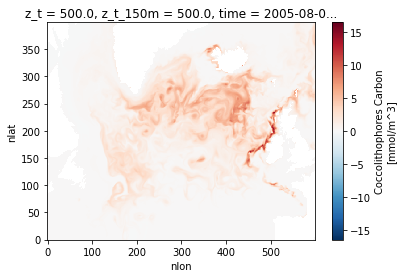

In [10]:
cocco_bloom.plot()

### Now grab the rest of the variables

In [57]:
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/month_1'

In [58]:
variables = ['coccoC','coccoCaCO3','PH','DIC','DIC_ALT_CO2','TEMP','CaCO3_PROD_zint']

In [59]:
def preprocess(ds):
    ds=ds.isel(z_t_150m=0)
    ds=ds.isel(z_t=0)
    ds=ds.isel(nlon=slice(500,1100),nlat=slice(1600,2000))
    return ds

In [60]:
ds_fosi_x01 = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    #ds_tmp = xr.open_dataset(path+case+'.pop.h.'+var+'.??????-??????.nc')
    #ds_tmp['time'] = time
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, preprocess=preprocess)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi_x01 = xr.merge([ds_fosi_x01,ds_tmp])

starting on  coccoC
starting on  coccoCaCO3
starting on  PH
starting on  DIC
starting on  DIC_ALT_CO2
starting on  TEMP
starting on  CaCO3_PROD_zint


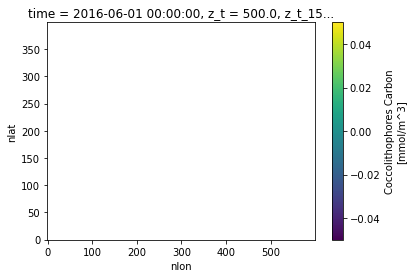

In [15]:
ds_fosi_x01.coccoC.isel(time=700).plot()

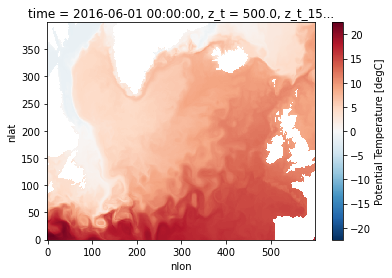

In [16]:
ds_fosi_x01.TEMP.isel(time=700).plot()

### we are missing biomass data for 2006 to 2021 cause that's in 5 day output

In [17]:
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/day_5'

In [18]:
variables = ['coccoC','coccoCaCO3']

In [19]:
%%time

ds2 = xr.Dataset()

for v in variables: 
    print(v)
    keep_vars = [v] +['dz','KMT','TLAT','TLONG','z_t_150m','z_t','time','time_bound']
    
    dsv = xr.Dataset()
    
    for year in np.arange(2006,2022,1):
        yr4="{:04d}".format(year)

        print(year)

        files = sorted(glob(f'{path}/{case}.pop.h.nday5.{v}.{yr4}0101-{yr4}1231.nc'))
        
        ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, preprocess=preprocess)

        ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars]).squeeze()
        ds_tmp = ds_tmp.mean(dim='time')
        dsv= xr.concat([dsv,ds_tmp],'time')
    ds2 = xr.merge([ds2,dsv])

coccoC
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
coccoCaCO3
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
CPU times: user 4.27 s, sys: 145 ms, total: 4.42 s
Wall time: 14.9 s


In [20]:
ds2

<xarray.Dataset>
Dimensions:     (nlat: 400, nlon: 600, time: 16)
Coordinates:
    z_t         float32 500.0
    z_t_150m    float32 500.0
    TLAT        (nlat, nlon) float64 38.84 38.85 38.85 ... 67.67 67.66 67.64
    TLONG       (nlat, nlon) float64 299.6 299.7 299.8 ... 7.307 7.435 7.563
Dimensions without coordinates: nlat, nlon, time
Data variables:
    coccoC      (time, nlat, nlon) float32 dask.array<chunksize=(1, 400, 600), meta=np.ndarray>
    KMT         (time, nlat, nlon) float64 dask.array<chunksize=(1, 400, 600), meta=np.ndarray>
    dz          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    coccoCaCO3  (time, nlat, nlon) float32 dask.array<chunksize=(1, 400, 600), meta=np.ndarray>

### spin up dask

In [94]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='01:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [95]:
cluster, client = get_ClusterClient()
cluster.scale(12) 

In [96]:
client

<Client: 'tcp://10.12.206.28:42996' processes=0 threads=0, memory=0 B>

In [24]:
ds_fosi_x01["time"] = ds_fosi_x01.time_bound.compute().mean(dim="d2")

In [25]:
ds_fosi_x01_ann = ds_fosi_x01.resample({'time':'A'}).mean(dim='time').compute()

In [26]:
ds_fosi_x01_ann

<xarray.Dataset>
Dimensions:      (nlat: 400, nlon: 600, time: 64)
Coordinates:
  * time         (time) object 1958-12-31 00:00:00 ... 2021-12-31 00:00:00
    z_t          float32 500.0
    z_t_150m     float32 500.0
    TLONG        (nlat, nlon) float64 299.6 299.7 299.8 ... 7.307 7.435 7.563
    TLAT         (nlat, nlon) float64 38.84 38.85 38.85 ... 67.67 67.66 67.64
Dimensions without coordinates: nlat, nlon
Data variables:
    dz           (time) float32 1e+03 1e+03 1e+03 1e+03 ... 1e+03 1e+03 1e+03
    coccoC       (time, nlat, nlon) float32 0.03429 0.03366 0.03303 ... nan nan
    coccoCaCO3   (time, nlat, nlon) float32 0.03488 0.03438 0.03379 ... nan nan
    PH           (time, nlat, nlon) float32 8.153 8.152 8.151 ... 8.089 8.09
    DIC          (time, nlat, nlon) float32 2.052e+03 2.052e+03 ... 2.168e+03
    DIC_ALT_CO2  (time, nlat, nlon) float32 2.031e+03 2.031e+03 ... 2.101e+03
    TEMP         (time, nlat, nlon) float32 22.2 22.2 22.19 ... 8.034 8.098

## Regional average timeseries

In [27]:
variables = ['coccoC','coccoCaCO3','PH','DIC','DIC_ALT_CO2','TEMP']

In [28]:
ds_x01_regmean = xr.Dataset()

for var in variables:
    
    masked_fosi = ds_fosi_x01_ann[var]
    masked_area = area.where(ds_grid.REGION_MASK > 0)
    ds_x01_regmean[var] = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))

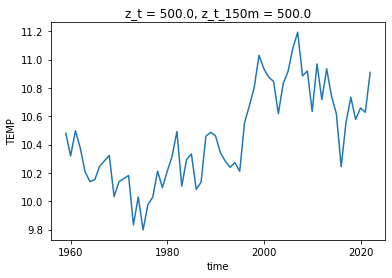

In [29]:
ds_x01_regmean.TEMP.plot()

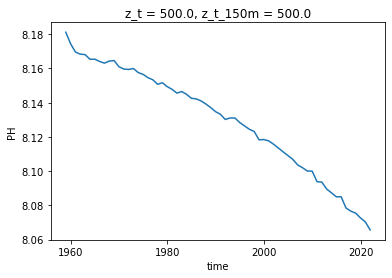

In [101]:
ds_x01_regmean.PH.plot()

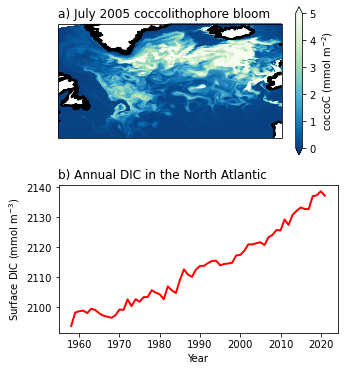

In [30]:
fig = plt.figure(figsize=(5,6))

############### 
ax = fig.add_subplot(2,1,1, projection=ccrs.PlateCarree())
ax.set_extent([-60, -7, 40, 67], ccrs.PlateCarree())

ax.set_title('a) July 2005 coccolithophore bloom', loc='left')

lon,lat,field = utils.adjust_pop_grid(ds_grid.TLONG, ds_grid.TLAT, cocco_bloom)

pc = ax.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='GnBu_r',
                   vmin=0,vmax=5)
ax.coastlines('10m',linewidth=2)
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='coccoC (mmol m$^{-2}$)')
    
############### 
ax = fig.add_subplot(2,1,2)

ax.set_title('b) Annual DIC in the North Atlantic', loc='left')

ax.plot(np.arange(1958,2022,1),ds_x01_regmean.DIC, linewidth=2, color='red')
ax.set(xlabel='Year',ylabel='Surface DIC (mmol m$^{-3}$)');

In [31]:
ds2.time.isel(time=slice(-5,16))

<xarray.DataArray 'time' (time: 5)>
array([11, 12, 13, 14, 15])
Coordinates:
    z_t       float32 500.0
    z_t_150m  float32 500.0
Dimensions without coordinates: time

In [90]:
picpoc1 = (ds_fosi_x01_ann.coccoCaCO3.isel(time=slice(0,5)).mean(dim='time'))/(ds_fosi_x01_ann.coccoC.isel(time=slice(0,5)).mean(dim='time'))

In [91]:
picpoc2 = (ds2.coccoCaCO3.isel(time=slice(-5,16)).mean(dim='time'))/(ds2.coccoC.isel(time=slice(-5,16)).mean(dim='time'))

In [92]:
picpoc_diff = picpoc2 - picpoc1

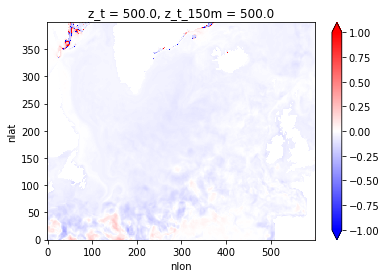

In [97]:
picpoc_diff.plot(vmin=-1,vmax=1,cmap='bwr')

In [39]:
ph1 = ds_fosi_x01_ann.PH.isel(time=slice(0,5)).mean(dim='time')
ph2 = ds_fosi_x01_ann.PH.isel(time=slice(-5,64)).mean(dim='time')

In [40]:
ph_diff = ph2 - ph1

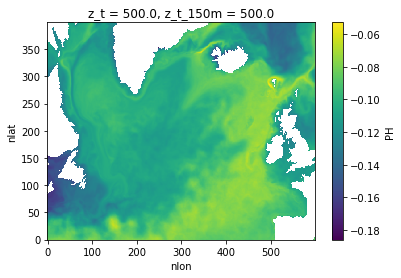

In [41]:
ph_diff.plot()

In [42]:
temp1 = ds_fosi_x01_ann.TEMP.isel(time=slice(0,5)).mean(dim='time')
temp2 = ds_fosi_x01_ann.TEMP.isel(time=slice(-5,64)).mean(dim='time')

In [43]:
temp_diff = temp2 - temp1

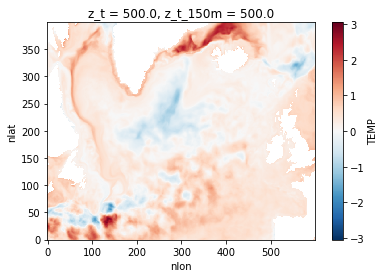

In [44]:
temp_diff.plot()

In [45]:
import matplotlib.gridspec as gridspec

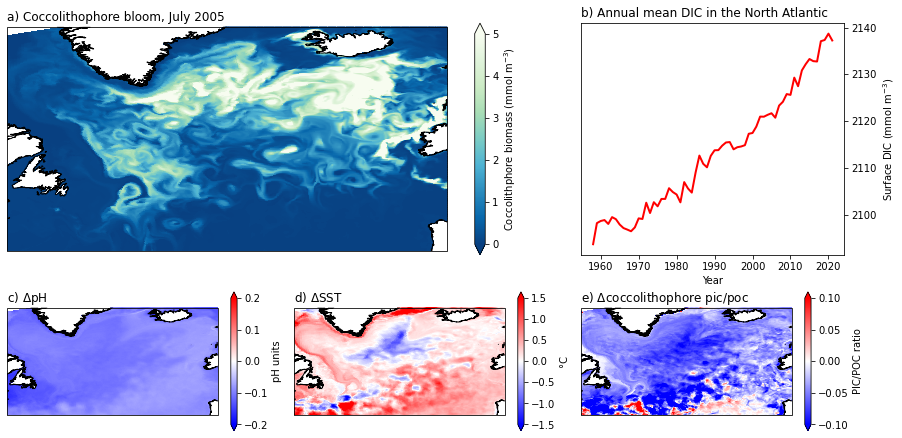

In [98]:
fig = plt.figure(figsize=(15, 7.5))

gs = gridspec.GridSpec(nrows=2, ncols=6, width_ratios=(1, 1, 1, 1, 1,1), height_ratios=(1,0.6))

prj = ccrs.PlateCarree()

ax_bloom = plt.subplot(gs[0,0:4], projection=prj)
ax_dicts = plt.subplot(gs[0,4:6])

ax_dPH = plt.subplot(gs[1, 0:2], projection=prj)
ax_dT = plt.subplot(gs[1, 2:4], projection=prj)
ax_dpicpoc = plt.subplot(gs[1, 4:6], projection=prj)

### Cocco bloom
ax_bloom.set_title('a) Coccolithophore bloom, July 2005', loc='left')
ax_bloom.set_extent([-60, -7, 40, 67], ccrs.PlateCarree())

lon,lat,field = utils.adjust_pop_grid(ds_grid.TLONG, ds_grid.TLAT, cocco_bloom)

pc = ax_bloom.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='GnBu_r',
                   vmin=0,vmax=5)
ax_bloom.coastlines('10m',linewidth=1)
cbar1 = fig.colorbar(pc,ax=ax_bloom,extend='both',label='Coccolithphore biomass (mmol m$^{-3}$)')
    
    
    
########### dic timeseries

ax_dicts.set_title('b) Annual mean DIC in the North Atlantic', loc='left')

ax_dicts.plot(np.arange(1958,2022,1),ds_x01_regmean.DIC, linewidth=2, color='red')
ax_dicts.set(xlabel='Year',ylabel='Surface DIC (mmol m$^{-3}$)');
ax_dicts.yaxis.set_label_position("right")
ax_dicts.yaxis.tick_right()


### pH change
ax_dPH.set_title('c) ${\Delta}$pH', loc='left')
ax_dPH.set_extent([-60, -7, 40, 67], ccrs.PlateCarree())

lon,lat,field = utils.adjust_pop_grid(ds_grid.TLONG, ds_grid.TLAT, ph_diff)

pc = ax_dPH.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',
                   vmin=-0.2,vmax=0.2)
ax_dPH.coastlines('10m',linewidth=1)
cbar1 = fig.colorbar(pc,ax=ax_dPH,extend='both',label='pH units')

### TEMP change
ax_dT.set_title('d) ${\Delta}$SST', loc='left')
ax_dT.set_extent([-60, -7, 40, 67], ccrs.PlateCarree())

lon,lat,field = utils.adjust_pop_grid(ds_grid.TLONG, ds_grid.TLAT, temp_diff)

pc = ax_dT.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',
                   vmin=-1.5,vmax=1.5)
ax_dT.coastlines('10m',linewidth=1)
cbar1 = fig.colorbar(pc,ax=ax_dT,extend='both',label='°C')

### picpoc change
ax_dpicpoc.set_title('e) ${\Delta}$coccolithophore pic/poc', loc='left')
ax_dpicpoc.set_extent([-60, -7, 40, 67], ccrs.PlateCarree())

lon,lat,field = utils.adjust_pop_grid(ds_grid.TLONG, ds_grid.TLAT, picpoc_diff)

pc = ax_dpicpoc.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',
                   vmin=-0.1,vmax=0.1)
ax_dpicpoc.coastlines('10m',linewidth=1)
cbar1 = fig.colorbar(pc,ax=ax_dpicpoc,extend='both',label='PIC/POC ratio')

fig.savefig('/glade/work/kristenk/figs/OA_coccofig.png', bbox_inches='tight', dpi=300, format='png');

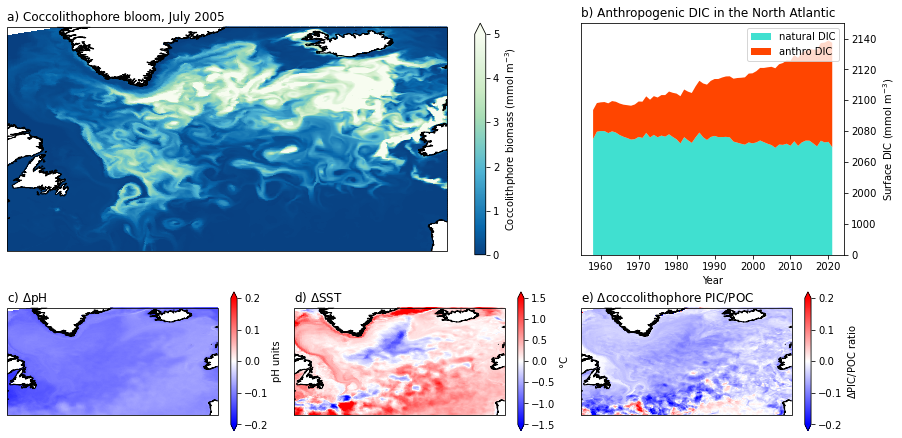

In [100]:
fig = plt.figure(figsize=(15, 7.5))

gs = gridspec.GridSpec(nrows=2, ncols=6, width_ratios=(1, 1, 1, 1, 1,1), height_ratios=(1,0.6))

prj = ccrs.PlateCarree()

ax_bloom = plt.subplot(gs[0,0:4], projection=prj)
ax_dicts = plt.subplot(gs[0,4:6])

ax_dPH = plt.subplot(gs[1, 0:2], projection=prj)
ax_dT = plt.subplot(gs[1, 2:4], projection=prj)
ax_dpicpoc = plt.subplot(gs[1, 4:6], projection=prj)

### Cocco bloom
ax_bloom.set_title('a) Coccolithophore bloom, July 2005', loc='left')
ax_bloom.set_extent([-60, -7, 40, 67], ccrs.PlateCarree())

lon,lat,field = utils.adjust_pop_grid(ds_grid.TLONG, ds_grid.TLAT, cocco_bloom)

pc = ax_bloom.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='GnBu_r',
                   vmin=0,vmax=5)
ax_bloom.coastlines('10m',linewidth=1)
cbar1 = fig.colorbar(pc,ax=ax_bloom,extend='max',label='Coccolithphore biomass (mmol m$^{-3}$)')
    
    
    
########### dic timeseries

ax_dicts.set_title('b) Anthropogenic DIC in the North Atlantic', loc='left')

#ax_dicts.plot(np.arange(1958,2022,1),ds_x01_regmean.DIC-ds_x01_regmean.DIC_ALT_CO2, linewidth=2, color='red')

ax_dicts.stackplot(np.arange(1958,2022,1),ds_x01_regmean.DIC_ALT_CO2,ds_x01_regmean.DIC-ds_x01_regmean.DIC_ALT_CO2, labels=["natural DIC","anthro DIC"], colors=['turquoise','orangered'])
ax_dicts.set_ylim(2000,2150)

labels = ['0','1000','2000','2060', '2080', '2100','2120','2140']
ax_dicts.set_yticklabels(labels)

ax_dicts.set(xlabel='Year',ylabel='Surface DIC (mmol m$^{-3}$)');
ax_dicts.yaxis.set_label_position("right")
ax_dicts.yaxis.tick_right()
ax_dicts.legend()


### pH change
ax_dPH.set_title('c) ${\Delta}$pH', loc='left')
ax_dPH.set_extent([-60, -7, 40, 67], ccrs.PlateCarree())

lon,lat,field = utils.adjust_pop_grid(ds_grid.TLONG, ds_grid.TLAT, ph_diff)

pc = ax_dPH.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',
                   vmin=-0.2,vmax=0.2)
ax_dPH.coastlines('10m',linewidth=1)
cbar1 = fig.colorbar(pc,ax=ax_dPH,extend='both',label='pH units')

### TEMP change
ax_dT.set_title('d) ${\Delta}$SST', loc='left')
ax_dT.set_extent([-60, -7, 40, 67], ccrs.PlateCarree())

lon,lat,field = utils.adjust_pop_grid(ds_grid.TLONG, ds_grid.TLAT, temp_diff)

pc = ax_dT.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',
                   vmin=-1.5,vmax=1.5)
ax_dT.coastlines('10m',linewidth=1)
cbar1 = fig.colorbar(pc,ax=ax_dT,extend='both',label='°C')

### picpoc change
ax_dpicpoc.set_title('e) ${\Delta}$coccolithophore PIC/POC', loc='left')
ax_dpicpoc.set_extent([-60, -7, 40, 67], ccrs.PlateCarree())

lon,lat,field = utils.adjust_pop_grid(ds_grid.TLONG, ds_grid.TLAT, picpoc_diff)

pc = ax_dpicpoc.pcolormesh(lon,lat,field,
                    transform=ccrs.PlateCarree(),cmap='bwr',
                   vmin=-0.2,vmax=0.2)
ax_dpicpoc.coastlines('10m',linewidth=1)
cbar1 = fig.colorbar(pc,ax=ax_dpicpoc,extend='both',label='${\Delta}$PIC/POC ratio')

fig.savefig('/glade/work/kristenk/figs/OA_coccofig.png', bbox_inches='tight', dpi=300, format='png');

### How much does pH drop globally ?

In [5]:
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/month_1'

In [6]:
def preprocess(ds):
    ds=ds.isel(z_t_150m=0)
    ds=ds.isel(z_t=0)
    return ds

In [8]:
%%time

ds1 = xr.Dataset()

for v in ['PH']: 
    print(v)
    keep_vars = [v] +['dz','KMT','TLAT','TLONG','z_t_150m','z_t','time','time_bound']
    
    dsv = xr.Dataset()
    
    for year in np.arange(1958,1963,1):
        yr4="{:04d}".format(year)

        print(year)

        files = sorted(glob(f'{path}/{case}.pop.h.{v}.{yr4}??-{yr4}??.nc'))
        
        ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, preprocess=preprocess)

        ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars]).squeeze()
        ds_tmp = ds_tmp.mean(dim='time')
        dsv= xr.concat([dsv,ds_tmp],'time')
    ds1 = xr.merge([ds1,dsv])

PH
1958
1959
1960
1961
1962
CPU times: user 2.34 s, sys: 406 ms, total: 2.75 s
Wall time: 3.43 s


In [9]:
%%time

ds2 = xr.Dataset()

for v in ['PH']: 
    print(v)
    keep_vars = [v] +['dz','KMT','TLAT','TLONG','z_t_150m','z_t','time','time_bound']
    
    dsv = xr.Dataset()
    
    for year in np.arange(2017,2022,1):
        yr4="{:04d}".format(year)

        print(year)

        files = sorted(glob(f'{path}/{case}.pop.h.{v}.{yr4}??-{yr4}??.nc'))
        
        ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",combine='nested',
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, preprocess=preprocess)

        ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars]).squeeze()
        ds_tmp = ds_tmp.mean(dim='time')
        dsv= xr.concat([dsv,ds_tmp],'time')
    ds2 = xr.merge([ds2,dsv])

PH
2017
2018
2019
2020
2021
CPU times: user 2.36 s, sys: 427 ms, total: 2.79 s
Wall time: 4.2 s


In [10]:
ds1= ds1.mean(dim='time')

In [11]:
ds2= ds2.mean(dim='time')

In [12]:
ph_diff = ds2.PH - ds1.PH

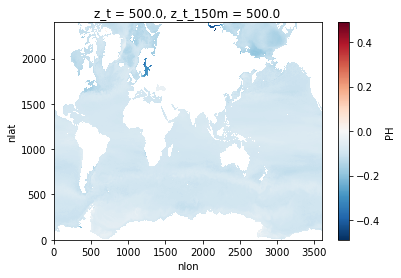

In [13]:
ph_diff.plot()

In [14]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
area_m=ds_grid.TAREA * 1e-4
lons_norm = utils.normal_lons(lons)

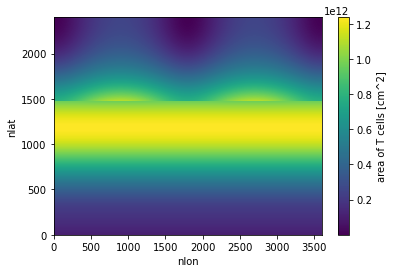

In [15]:
area.plot()

In [17]:
global_mean_ph_change = (ph_diff * area).sum(dim=('nlon','nlat'))/area.sum(dim=('nlon','nlat'))

In [18]:
global_mean_ph_change.values

array(-0.06458879)